*This example is a Jupyter notebook. You can download it or run it interactively on mybinder.org.*

# Linear regression

## Data

The true parameters of the linear regression:

In [40]:
import numpy as np
import matplotlib.pyplot as plt
k = 2 # slope
c = 5 # bias
s = 15 # noise standard deviation

In [41]:
# This cell content is hidden from Sphinx-generated documentation
%matplotlib inline
np.random.seed(42)

Generate data:

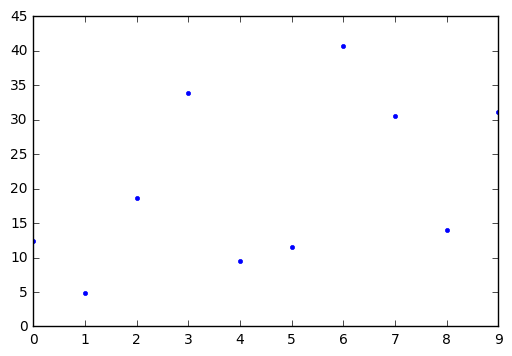

In [42]:
x = np.arange(10)
y = k*x + c + np.random.normal(loc=0, scale=s, size=len(x))
_ = plt.plot(x,y,'.')

## Model

The regressors, that is, the input data:

In [43]:
X = np.vstack([x, np.ones(len(x))]).T

Note that we added a column of ones to the regressor matrix for the bias term. We model the slope and the bias term in the same node so we do not factorize between them:

In [44]:
from bayespy.nodes import GaussianARD
B = GaussianARD(0, 1e-6, shape=(2,))

The first element is the slope which multiplies x and the second element is the bias term which multiplies the constant ones. Now we compute the dot product of X and B:

In [45]:
from bayespy.nodes import SumMultiply
F = SumMultiply('i,i', B, X)

The noise parameter:

In [46]:
from bayespy.nodes import Gamma
tau = Gamma(1e-3, 1e-3)

The noisy observations:

In [47]:
Y = GaussianARD(F, tau)

## Inference

Observe the data:

In [48]:
Y.observe(y)

Construct the variational Bayesian (VB) inference engine by giving all stochastic nodes:

In [49]:
from bayespy.inference import VB
Q = VB(Y, B, tau)

Iterate until convergence:

In [50]:
Q.update(repeat=1000)

Iteration 1: loglike=-6.046629e+01 (0.006 seconds)
Iteration 2: loglike=-5.670713e+01 (0.005 seconds)
Iteration 3: loglike=-5.668907e+01 (0.004 seconds)
Iteration 4: loglike=-5.668845e+01 (0.004 seconds)
Iteration 5: loglike=-5.668842e+01 (0.007 seconds)
Converged at iteration 5.


## Results

Create a simple predictive model for new inputs:

In [51]:
xh = np.linspace(-5, 15, 100)
Xh = np.vstack([xh, np.ones(len(xh))]).T
Fh = SumMultiply('i,i', B, Xh)

Note that we use the learned node B but create a new regressor array for predictions. Plot the predictive distribution of noiseless function values:

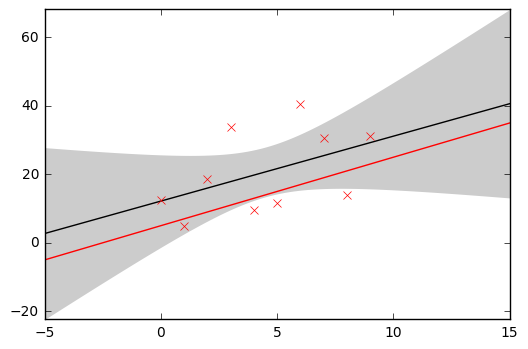

In [52]:
import bayespy.plot as bpplt
bpplt.pyplot.figure()
bpplt.plot(Fh, x=xh, scale=2)
bpplt.plot(y, x=x, color='r', marker='x', linestyle='None')
bpplt.plot(k*xh+c, x=xh, color='r');

Note that the above plot shows two standard deviation of the posterior of the noiseless function, thus the data points may lie well outside this range. The red line shows the true linear function. Next, plot the distribution of the noise parameter and the true value, 2−2=0.25:

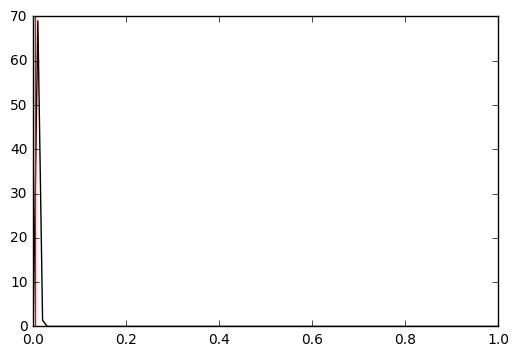

In [53]:
bpplt.pyplot.figure()
bpplt.pdf(tau, np.linspace(1e-6,1,100), color='k')
bpplt.pyplot.axvline(s**(-2), color='r');

The noise level is captured quite well, although the posterior has more mass on larger noise levels (smaller precision parameter values). Finally, plot the distribution of the regression parameters and mark the true value:

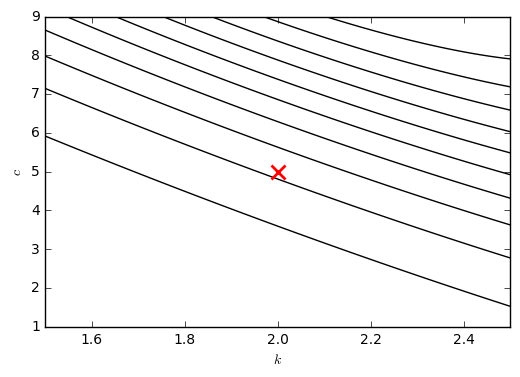

In [54]:
bpplt.pyplot.figure();
bpplt.contour(B, np.linspace(1.5,2.5,1000), np.linspace(1,9,1000),
              n=10, colors='k');
bpplt.plot(c, x=k, color='r', marker='x', linestyle='None',
           markersize=10, markeredgewidth=2)
bpplt.pyplot.xlabel(r'$k$');
bpplt.pyplot.ylabel(r'$c$');

In this case, the true parameters are captured well by the posterior distribution.

## Improving accuracy

The model can be improved by not factorizing between B and tau but learning their joint posterior distribution. This requires a slight modification to the model by using GaussianGammaISO node:

In [55]:
from bayespy.nodes import GaussianGamma
B_tau = GaussianGamma(np.zeros(2), 1e-6*np.identity(2), 1e-3, 1e-3)

This node contains both the regression parameter vector and the noise parameter. We compute the dot product similarly as before:

In [56]:
F_tau = SumMultiply('i,i', B_tau, X)

However, Y is constructed as follows:

In [57]:
Y = GaussianARD(F_tau, 1)

Because the noise parameter is already in F_tau we can give a constant one as the second argument. The total noise parameter for Y is the product of the noise parameter in F_tau and one. Now, inference is run similarly as before:

In [58]:
Y.observe(y)
Q = VB(Y, B_tau)
Q.update(repeat=1000)

Iteration 1: loglike=-6.145676e+01 (0.003 seconds)
Iteration 2: loglike=-6.145676e+01 (0.003 seconds)
Converged at iteration 2.


Note that the method converges immediately. This happens because there is only one unobserved stochastic node so there is no need for iteration and the result is actually the exact true posterior distribution, not an approximation. Currently, the main drawback of using this approach is that BayesPy does not yet contain any plotting utilities for nodes that contain both Gaussian and gamma variables jointly.

## Further extensions

The approach discussed in this example can easily be extended to non-linear regression and multivariate regression. For non-linear regression, the inputs are first transformed by some known non-linear functions and then linear regression is applied to this transformed data. For multivariate regression, X and B are concatenated appropriately: If there are more regressors, add more columns to both X and B. If there are more output dimensions, add plates to B.